In [1]:
SF = 10
schema = f'CH{SF:02d}'
ssd_cache    = True


In [2]:
!pip install duckdb --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 85.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.0.0
    Uninstalling duckdb-1.0.0:
      Successfully uninstalled duckdb-1.0.0


In [3]:
### for testing keep it False
result_cache = False

**<mark><u>Import</u></mark>**

In [4]:
import duckdb
import pathlib
from   deltalake import convert_to_deltalake, DeltaTable
import time
import pandas as pd
from   deltalake.writer import write_deltalake
from   datetime import datetime
from   sqlglot import parse_one, exp
from   psutil import *
from   cachetools import cached, LRUCache

In [5]:
core=cpu_count()
core

2

# Generate Delta

In [6]:
%%time
Table_Path = '/lakehouse/default/Tables'
if not pathlib.Path(f'{Table_Path}/CH{SF:02d}').exists():
  for x in range(0, SF) :
    con=duckdb.connect()
    con.sql(f"CALL dbgen(sf={SF} , children ={SF}, step = {x})")
    for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
        pathlib.Path(f'{Table_Path}/CH{SF:02d}/{tbl}').mkdir(parents=True, exist_ok=True)
        con.sql(f"""  COPY (SELECT * FROM {tbl}) TO '{Table_Path}/CH{SF:02d}/{tbl}' (FORMAT PARQUET,PER_THREAD_OUTPUT TRUE,APPEND) """)
    con.close()
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
      convert_to_deltalake(f'{Table_Path}/CH{SF:02d}/{tbl}',storage_options={"allow_unsafe_rename":"true"})
else:
  print("Already Generated")

Already Generated
CPU times: user 0 ns, sys: 1.59 ms, total: 1.59 ms
Wall time: 171 ms


<mark>**Initiate an Empty Local DB**</mark>

In [7]:
con = duckdb.connect(f'temp_CH{schema}.duckdb')
con.sql('SET preserve_insertion_order=false')
con.sql(""" create table if not exists delta(tbl string , version int,id string PRIMARY KEY) """)

# SQL Query

In [8]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;


SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;








SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;








SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;







SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;







SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;








SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{SF})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;








SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    supplier_no
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;








SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );






SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;





SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );






SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;






SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;






SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;

''')

# Utility Function

In [9]:
def disk_cache(sql_query):
    if ssd_cache is True :
        tbl_type ='table'
    else:
        tbl_type ='view'
    start = time.time()
    print(tbl_type)
    data =[]
    tbl_list = [table.name for table in parse_one(sql_query).find_all(exp.Table)]
    tbl_list = sorted(list(set(tbl_list))) # remove duplicate
    for tbl in tbl_list :
            try :
                dt = DeltaTable(f'/lakehouse/default/Tables/{schema}/{tbl}')
                version =dt.version()
                table_id = dt.metadata().id
                data.append({'tbl': tbl, 'version': version,'id':table_id})
            except  Exception as er:
              print(f"this table is a CTE :{tbl}")         
    deltaonelake = pd.DataFrame(data)

    result =con.sql(" select tbl, version, id from deltaonelake where concat(id,cast (id as string))  not in (select concat(id,cast (id as string)) from delta)").fetchall()
    if len(result)==0:
        print ('all cacheed')
    else:
        for tbl, version, id in result:
            print(f"caching {tbl}")
            con.sql(f''' CREATE or replace {tbl_type}  {tbl} AS SELECT * FROM delta_scan('/lakehouse/default/Tables/{schema}/{tbl}') ''')
            con.sql(f''' INSERT OR REPLACE INTO delta VALUES ('{tbl}',{version}, '{id}'); ''')
            print(f"done")
        con.sql('checkpoint ;')
    print('sync to disk: ' + str(time.time()-start))
    return  ' '.join(deltaonelake.stack().astype(str))

In [10]:
if result_cache is True :
    @cached(cache=LRUCache(maxsize=32))
    def run_one_query(sql,metadata):
      return con.sql(sql).show()
else:
    def run_one_query(sql,metadata):
       return con.sql(sql).show()

In [11]:
def execute_multiplequery(sql_script):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            metadata = disk_cache(value)
            result = run_one_query(value,metadata)
            display(result)
            duration = time.time()-start
            print(duration)
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

# Run Tests

In [12]:
%%time
df=execute_multiplequery(sql)
df['Engine']        = 'duckdb_First_Run'
df['disk_cache']    = ssd_cache
df['result_cache']  = result_cache
df['time']          = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf']            = SF
df['cpu']           = core
df['test']          = 'tpch'
write_deltalake('/lakehouse/default/Tables/dbo/duckdbresult',df,mode="append",storage_options={"allow_unsafe_rename":"true"},engine='rust') 

Query1
table
caching lineitem


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

caching nation
done
caching part


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
caching partsupp


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
caching region
done
caching supplier
done
sync to disk: 16.233610153198242
┌───────────────┬────────────────────┬────────────────┬───────────┬────────────────┬────────────────────────────────────────┬─────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────┐
│   s_acctbal   │       s_name       │     n_name     │ p_partkey │     p_mfgr     │               s_address                │     s_phone     │                                            s_comment                                             │
│ decimal(15,2) │      varchar       │    varchar     │   int64   │    varchar     │                varchar                 │     varchar     │                                             varchar                                              │
├───────────────┼────────────────────┼────────────────┼───────────┼────────────────┼────────────────────────────────────────┼─────────────────┼────────────────────────────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
caching orders


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
sync to disk: 25.348624229431152
┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int64    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│    4791171 │   440715.2185 │ 1995-02-23  │              0 │
│   46678469 │   439855.3250 │ 1995-01-27  │              0 │
│   23906758 │   432728.5737 │ 1995-03-14  │              0 │
│   23861382 │   428739.1368 │ 1995-03-09  │              0 │
│   59393639 │   426036.0662 │ 1995-02-12  │              0 │
│    3355202 │   425100.6657 │ 1995-03-04  │              0 │
│    9806272 │   425088.0568 │ 1995-03-13  │              0 │
│   22810436 │   423231.9690 │ 1995-01-02  │              0 │
│   16384100 │   421478.7294 │ 1995-03-02  │              0 │
│   52974151 │   415367.1195 │ 1995-02-05  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                       

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

2.7533886432647705
Query14
table
all cacheed
sync to disk: 0.042501211166381836
┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

0.6506626605987549
Query15
table
all cacheed
sync to disk: 0.050193071365356445
┌─────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬─────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │  decimal(38,2)  │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼─────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │          318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │          304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │          322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │          312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │          327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │          327.00 │
│ Customer#001492954 │   1492954 │   303

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

3.2241990

In [13]:
%%time
df=execute_multiplequery(sql)
df['Engine']        = 'duckdb_Second_Run'
df['disk_cache']    = ssd_cache
df['result_cache']  = result_cache
df['time']          = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf']            = SF
df['cpu']           = core
df['test']          = 'tpch'
write_deltalake('/lakehouse/default/Tables/dbo/duckdbresult',df,mode="append",storage_options={"allow_unsafe_rename":"true"},engine='rust') 

┌───────────────┬────────────────────┬────────────────┬───────────┬────────────────┬────────────────────────────────────────┬─────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────┐
│   s_acctbal   │       s_name       │     n_name     │ p_partkey │     p_mfgr     │               s_address                │     s_phone     │                                            s_comment                                             │
│ decimal(15,2) │      varchar       │    varchar     │   int64   │    varchar     │                varchar                 │     varchar     │                                             varchar                                              │
├───────────────┼────────────────────┼────────────────┼───────────┼────────────────┼────────────────────────────────────────┼─────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────┤
│       9994.37 │ Supplier#0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

2.9314382076263428
Query14
table
all cacheed
sync to disk: 0.045041561126708984
┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

0.6266734600067139
Query15
table
all cacheed
sync to disk: 0.04178118705749512
┌──────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬─────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │  decimal(38,2)  │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼─────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │          318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │          304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │          322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │          312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │          327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │          327.00 │
│ Customer#001492954 │   1492954 │   303

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

3.3747713

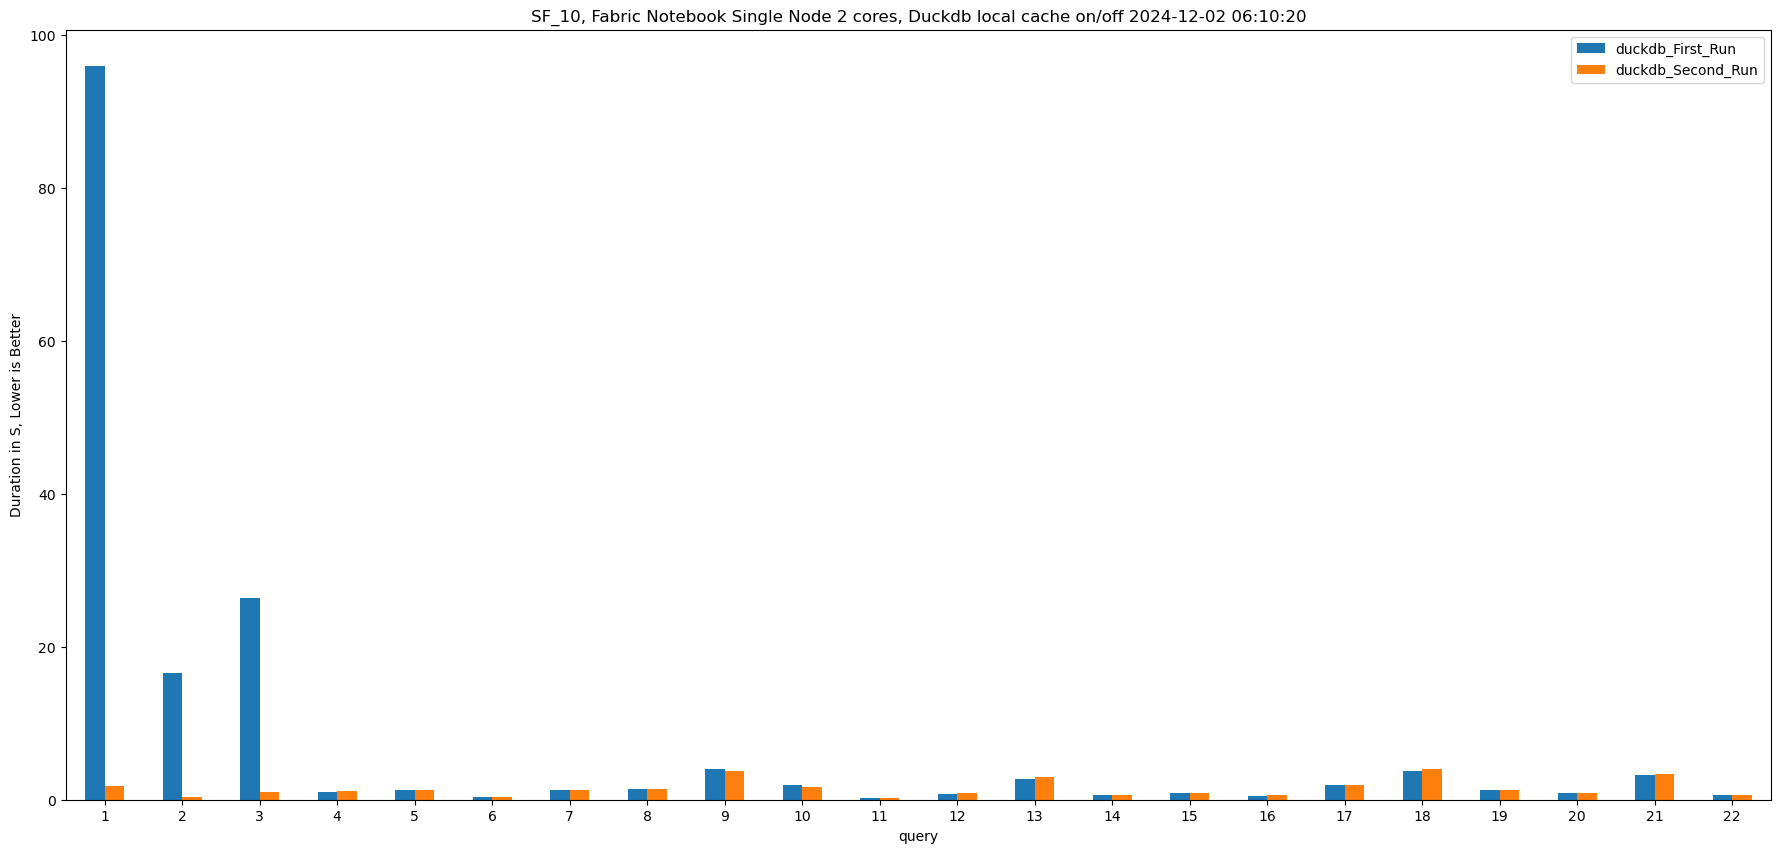

In [14]:
pv = duckdb.sql(f"""PIVOT ( select Engine,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch') ON Engine using avg(dur) order by query""")
xx = duckdb.sql(f" select query, sum(COLUMNS(*exclude(sf,query))) from pv  group by all order by query  ").df()
ax = xx.plot.bar(rot=0,x='query',title=f"SF_{SF}, Fabric Notebook Single Node {core} cores, Duckdb local cache on/off " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'),ylabel='Duration in S, Lower is Better',figsize=(22,10))

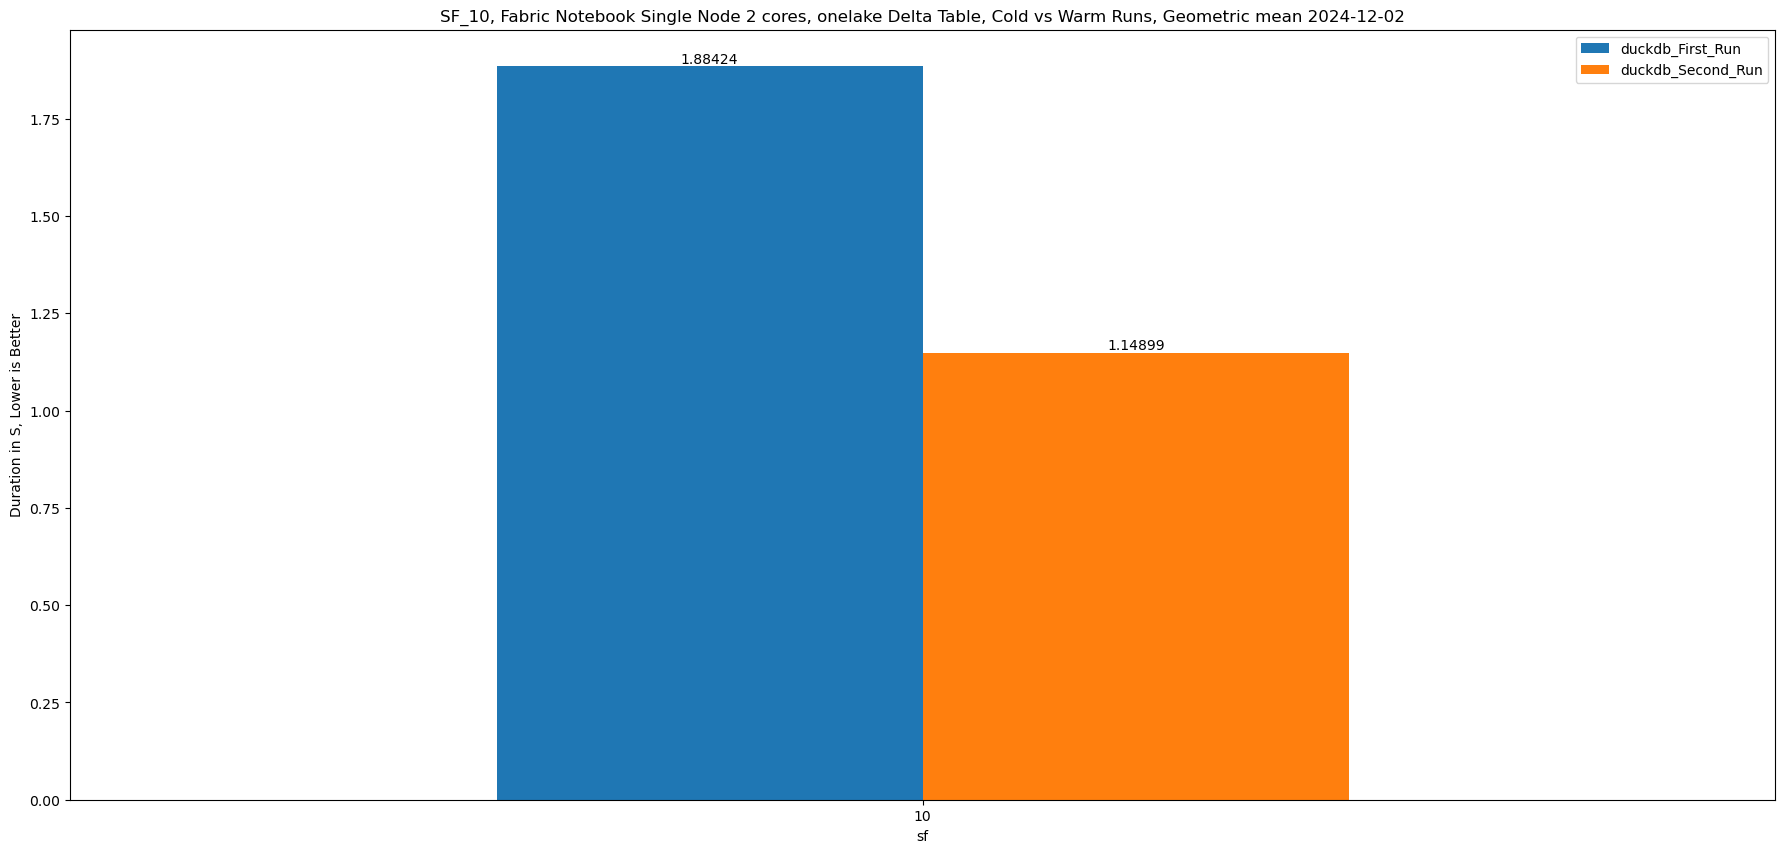

In [15]:
pv = duckdb.sql(f"""PIVOT ( select Engine,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON Engine using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, geomean(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"SF_{SF}, Fabric Notebook Single Node {core} cores, onelake Delta Table, Cold vs Warm Runs, Geometric mean " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

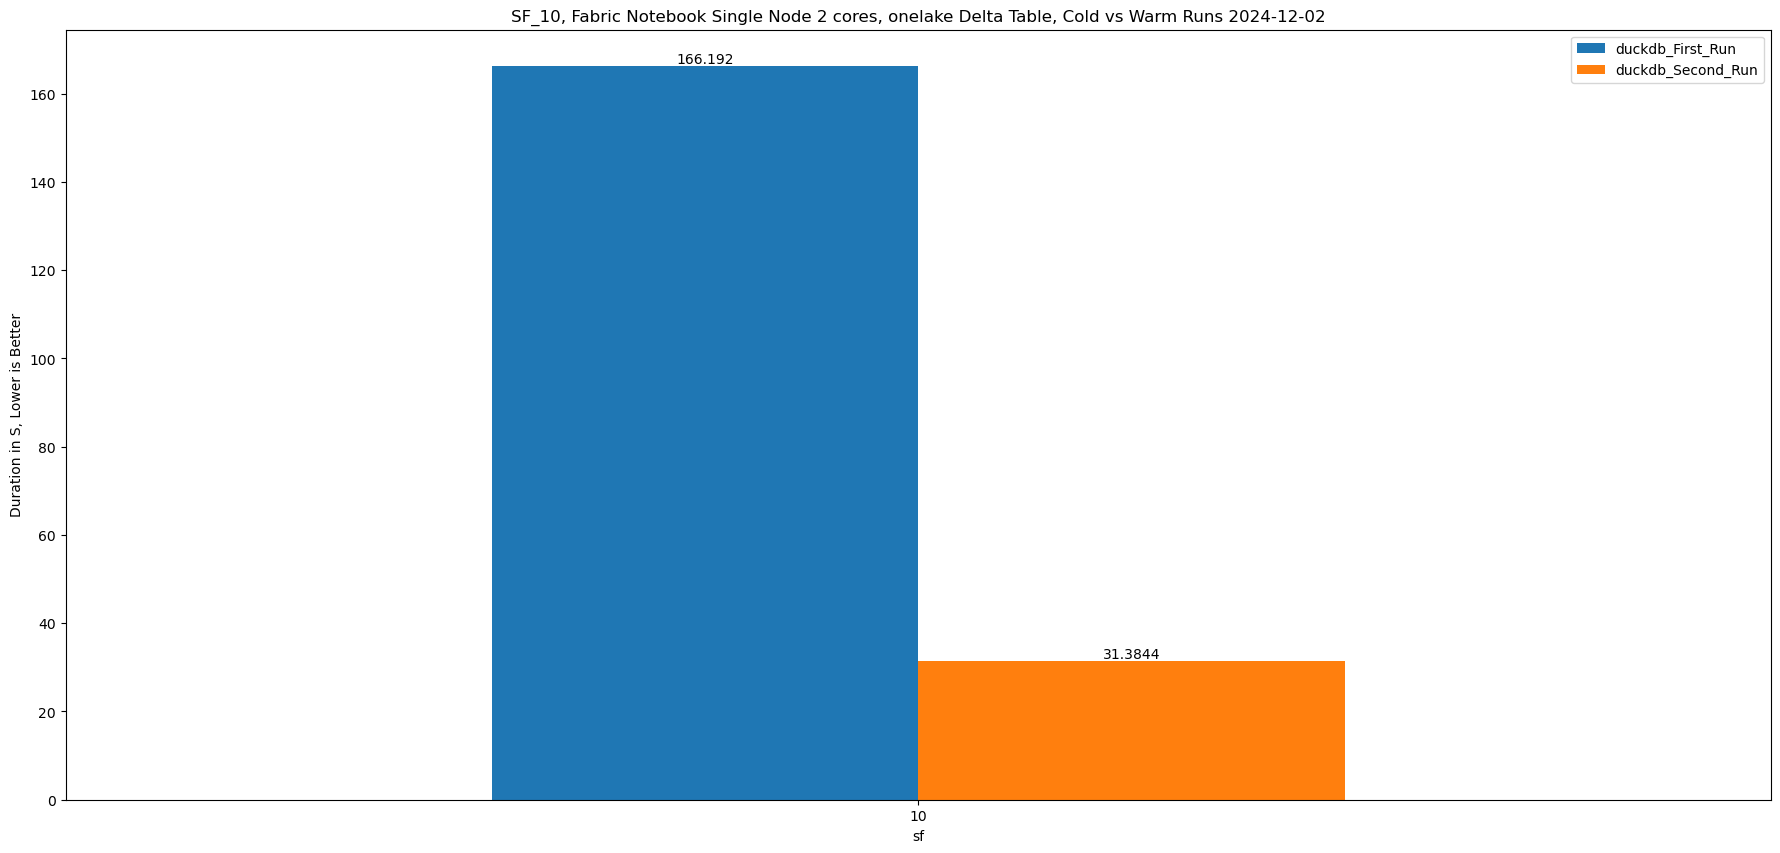

In [16]:
pv = duckdb.sql(f"""PIVOT ( select Engine,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON Engine using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, sum(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"SF_{SF}, Fabric Notebook Single Node {core} cores, onelake Delta Table, Cold vs Warm Runs " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')